<a href="https://colab.research.google.com/github/Jesteban247/ML-College/blob/main/Tech_ML/Projects/Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Setup and Libraries**


In [31]:
# Setup and Libraries
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.decomposition import PCA

# **2. Data Loading and Initial Inspection**

In [2]:
# Load Data
url = 'https://datosabiertos.bogota.gov.co/dataset/8624f916-1db2-4c17-b669-19a19b35d1ca/resource/f5862aaa-4e1c-463e-94d5-f04db8164360/download/historico_siniestros_bogota_d.c_-.csv'
df = pd.read_csv(url)

# Quick inspection of the data
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199146 entries, 0 to 199145
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   X                     199146 non-null  float64
 1   Y                     199146 non-null  float64
 2   OBJECTID              199146 non-null  int64  
 3   FORMULARIO            199146 non-null  object 
 4   CODIGO_ACCIDENTE      199146 non-null  int64  
 5   FECHA_OCURRENCIA_ACC  199146 non-null  object 
 6   ANO_OCURRENCIA_ACC    199146 non-null  int64  
 7   DIRECCION             199146 non-null  object 
 8   GRAVEDAD              199146 non-null  object 
 9   CLASE_ACC             199146 non-null  object 
 10  LOCALIDAD             199100 non-null  object 
 11  FECHA_HORA_ACC        199146 non-null  object 
 12  LATITUD               199146 non-null  float64
 13  LONGITUD              199146 non-null  float64
 14  CIV                   197445 non-null  float64
 15  


# **3. Data Preparation**

**Column Descriptions**

1. **X**: Coordinate value on the X-axis.
2. **Y**: Coordinate value on the Y-axis.
3. **OBJECTID**: Unique identifier for each record.
4. **FORMULARIO**: Form or document number associated with the accident report.
5. **CODIGO_ACCIDENTE**: Unique accident code.
6. **FECHA_OCURRENCIA_ACC**: Date the accident occurred.
7. **ANO_OCURRENCIA_ACC**: Year the accident occurred.
8. **DIRECCION**: Address where the accident happened.
9. **GRAVEDAD**: Severity level of the accident (e.g., fatal, serious, minor).
10. **CLASE_ACC**: Type of accident (e.g., collision, pedestrian involved).
11. **LOCALIDAD**: Location or locality within the city.
12. **FECHA_HORA_ACC**: Date and time of the accident.
13. **LATITUD**: Latitude coordinate of the accident location.
14. **LONGITUD**: Longitude coordinate of the accident location.
15. **CIV**: Potentially a category or identifier related to infrastructure or road segment.
16. **PK_CALZADA**: Road or pavement identifier, possibly the segment of the street.

**Key Columns for Classification or Clustering**

1. **GRAVEDAD**: Critical for classifying the severity of accidents. (Only Death)
2. **CLASE_ACC**: Important for categorizing accident types.
3. **LOCALIDAD**: Useful for clustering by geographic or urban area.
4. **LATITUD & LONGITUD** (or **X & Y**): Essential for spatial clustering.
5. **ANO_OCURRENCIA_ACC**: Can be useful for time-based classification or clustering trends.
6. **FECHA_OCURRENCIA_ACC** and **FECHA_HORA_ACC**: Helpful for time-based clustering if focusing on daily or hourly patterns.


In [3]:
# Filter Data by Deaths
df_deaths = df[df['GRAVEDAD'] == 'CON MUERTOS']
df_deaths.reset_index(drop=True, inplace=True)

# Select Key Columns for Analysis
df_selected = df_deaths[['CLASE_ACC', 'LOCALIDAD', 'LATITUD', 'LONGITUD', 'ANO_OCURRENCIA_ACC', 'FECHA_HORA_ACC']].copy()

# Convert 'FECHA_HORA_ACC' to datetime and extract time features
df_selected['FECHA_HORA_ACC'] = pd.to_datetime(df_selected['FECHA_HORA_ACC'], errors='coerce')
df_selected['Month'] = df_selected['FECHA_HORA_ACC'].dt.month
df_selected['Day'] = df_selected['FECHA_HORA_ACC'].dt.day
df_selected['Hour'] = df_selected['FECHA_HORA_ACC'].dt.hour

# Drop original date-time column
df_selected.drop(columns=['FECHA_HORA_ACC'], inplace=True)

# Handle missing values by dropping rows with nulls
df_selected.dropna(inplace=True)

# Check for null values
df_selected.isnull().sum()
df_selected.head()

,CLASE_ACC,LOCALIDAD,LATITUD,LONGITUD,ANO_OCURRENCIA_ACC,Month,Day,Hour
0,ATROPELLO,SUBA,4.778000,-74.042000,2020,8,3,14
1,ATROPELLO,USME,4.508000,-74.113000,2020,9,14,21
2,ATROPELLO,BARRIOS UNIDOS,4.660000,-74.077000,2020,8,22,19
3,VOLCAMIENTO,CIUDAD BOLIVAR,4.526321,-74.140893,2018,5,19,20
4,CHOQUE,KENNEDY,4.616000,-74.158000,2020,12,22,15


In [4]:
# Show the selected df
df_selected.head()

,CLASE_ACC,LOCALIDAD,LATITUD,LONGITUD,ANO_OCURRENCIA_ACC,Month,Day,Hour
0,ATROPELLO,SUBA,4.778000,-74.042000,2020,8,3,14
1,ATROPELLO,USME,4.508000,-74.113000,2020,9,14,21
2,ATROPELLO,BARRIOS UNIDOS,4.660000,-74.077000,2020,8,22,19
3,VOLCAMIENTO,CIUDAD BOLIVAR,4.526321,-74.140893,2018,5,19,20
4,CHOQUE,KENNEDY,4.616000,-74.158000,2020,12,22,15


# **4. Exploratory Data Analysis (EDA)**

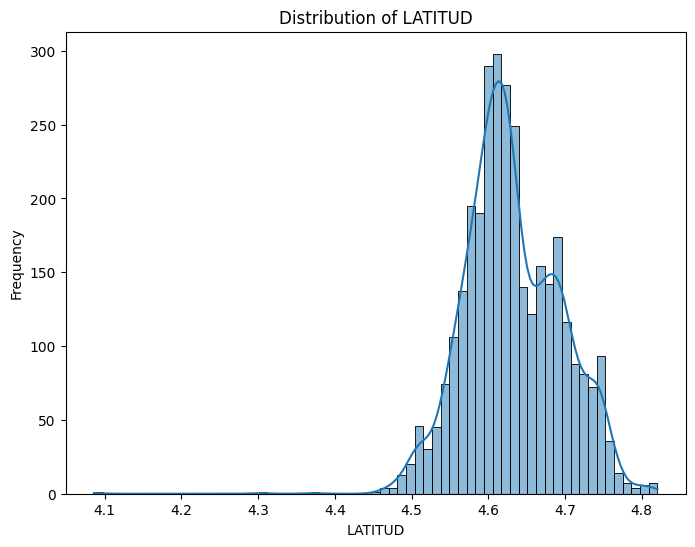

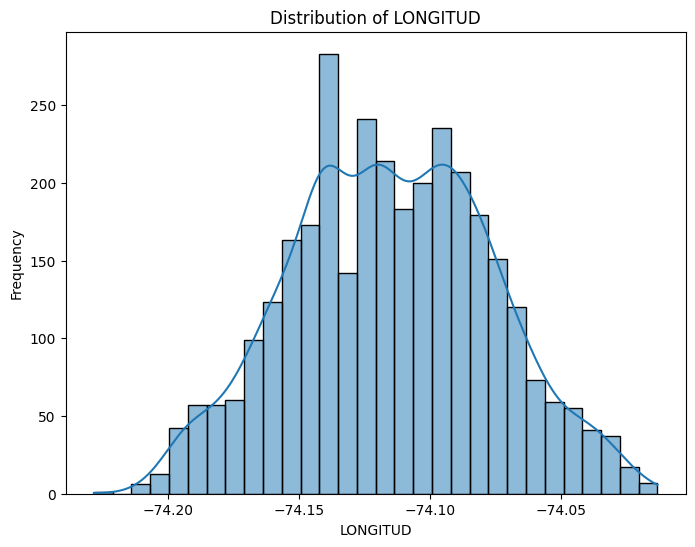

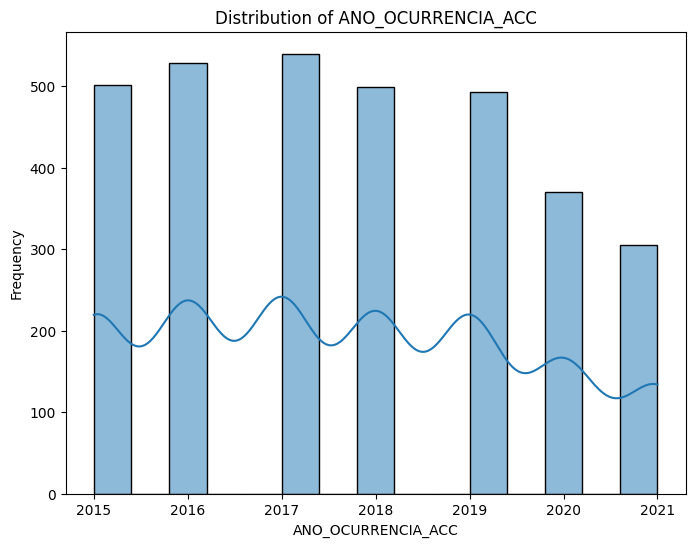

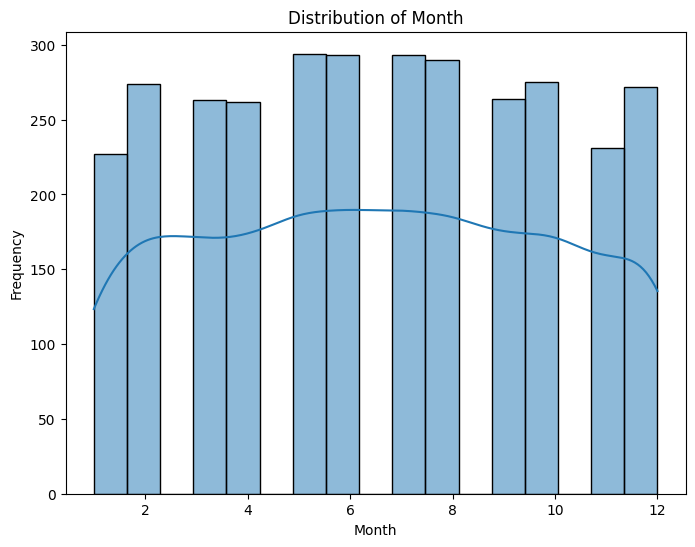

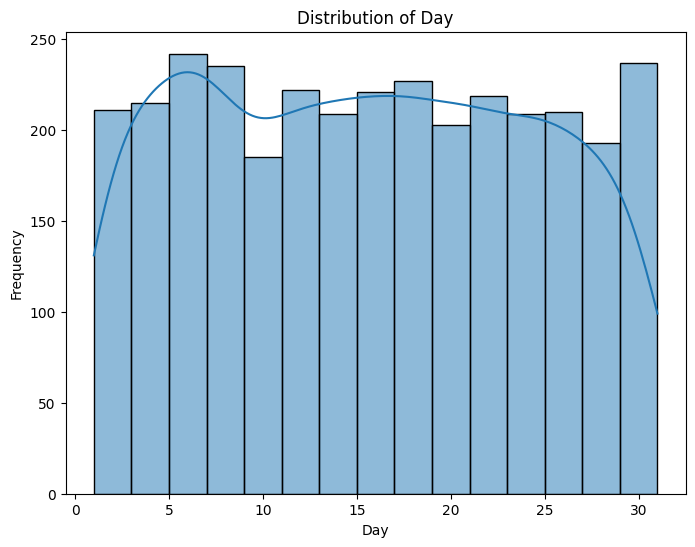

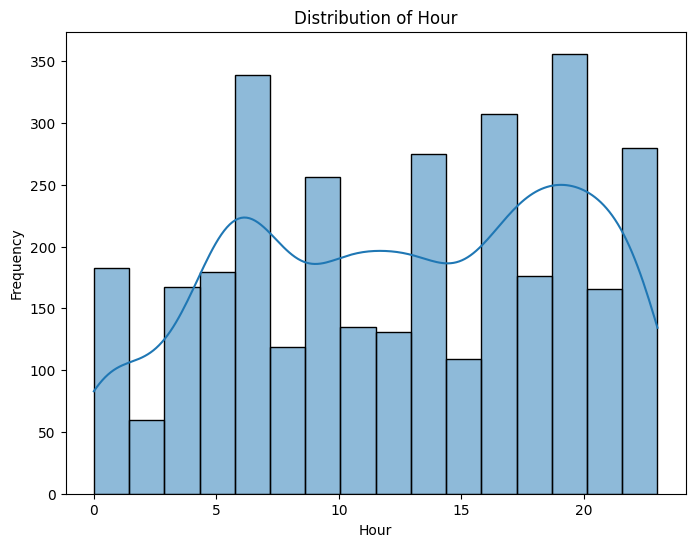

In [5]:
# Numerical Distributions
numerical_cols = df_selected.select_dtypes(include=np.number).columns

for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(df_selected[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

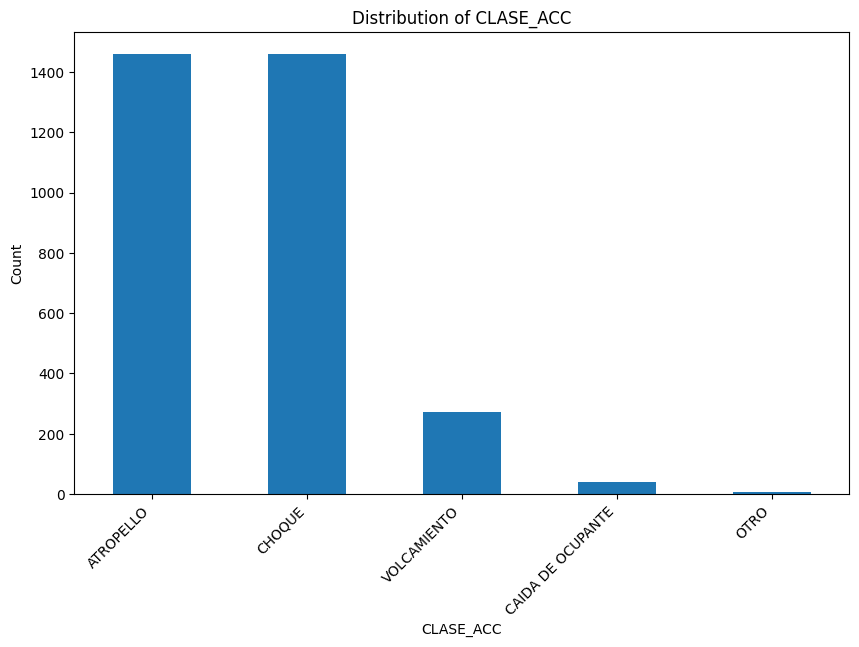

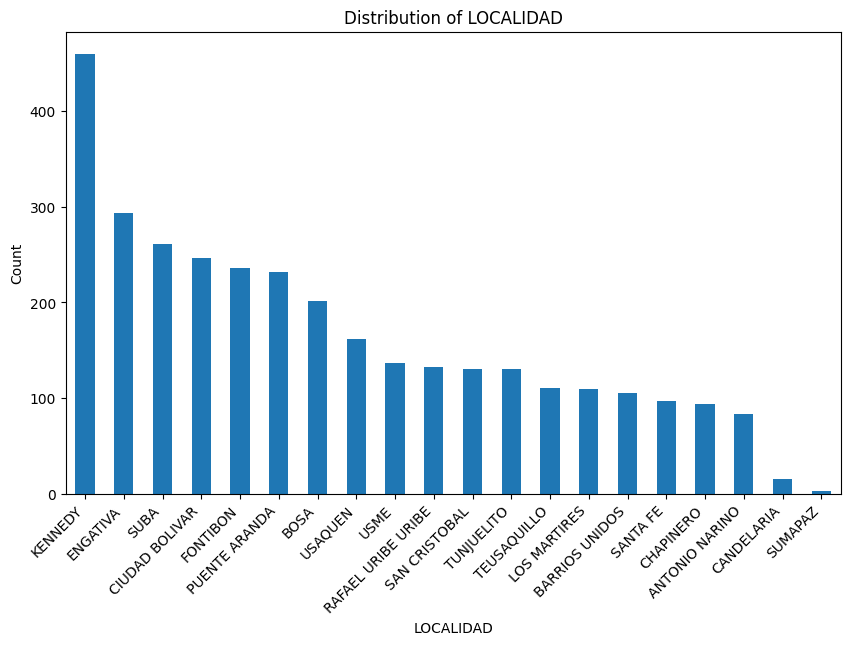

In [6]:
# Categorical Distributions
categorical_cols = df_selected.select_dtypes(exclude=np.number).columns

for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    df_selected[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [7]:
# Geographical Analysis 1
fig = px.scatter_mapbox(
    df_selected,
    lat="LATITUD",
    lon="LONGITUD",
    color="LOCALIDAD",
    mapbox_style="carto-positron",
    zoom=10,
    center={"lat": 4.65, "lon": -74.1},
    title="Accidents in Bogotá"
)
fig.show()

In [8]:
# Geographical Analysis 2
fig = px.scatter_mapbox(
    df_selected,
    lat="LATITUD",
    lon="LONGITUD",
    color="CLASE_ACC",
    mapbox_style="carto-positron",
    zoom=10,
    center={"lat": 4.65, "lon": -74.1},
    title="Accidents in Bogotá"
)
fig.show()

# **5. Outlier Removal**

In [9]:
# Row count before removing outliers
initial_row_count = df_selected.shape[0]

# Calculate the IQR for latitude and longitude
Q1_lat, Q3_lat = df_selected['LATITUD'].quantile(0.25), df_selected['LATITUD'].quantile(0.75)
IQR_lat = Q3_lat - Q1_lat
lower_bound_lat = Q1_lat - 1.5 * IQR_lat
upper_bound_lat = Q3_lat + 1.5 * IQR_lat

Q1_lon, Q3_lon = df_selected['LONGITUD'].quantile(0.25), df_selected['LONGITUD'].quantile(0.75)
IQR_lon = Q3_lon - Q1_lon
lower_bound_lon = Q1_lon - 1.5 * IQR_lon
upper_bound_lon = Q3_lon + 1.5 * IQR_lon

# Filter out rows outside IQR bounds
df_selected = df_selected[
    (df_selected['LATITUD'] >= lower_bound_lat) &
    (df_selected['LATITUD'] <= upper_bound_lat) &
    (df_selected['LONGITUD'] >= lower_bound_lon) &
    (df_selected['LONGITUD'] <= upper_bound_lon)
]

# Row count after removing outliers
final_row_count = df_selected.shape[0]
print(f"Rows before outlier removal: {initial_row_count}")
print(f"Rows after outlier removal: {final_row_count}")
print(f"Number of rows removed: {initial_row_count - final_row_count}")

Rows before outlier removal: 3238
Rows after outlier removal: 3224
Number of rows removed: 14


# **6. Data Transformation**

In [10]:
# Drop specific values
df_selected = df_selected[~df_selected['CLASE_ACC'].isin(['CAIDA DE OCUPANTE', 'OTRO'])]
df_selected = df_selected[df_selected['LOCALIDAD'] != 'SUMAPAZ']

# Column counts for categorical columns
for col in categorical_cols:
    print(f"Column: {col}")
    print(df_selected[col].value_counts())
    print("-" * 20)

Column: CLASE_ACC
CLASE_ACC
ATROPELLO      1457
CHOQUE         1452
VOLCAMIENTO     266
Name: count, dtype: int64
--------------------
Column: LOCALIDAD
LOCALIDAD
KENNEDY               453
ENGATIVA              291
SUBA                  254
CIUDAD BOLIVAR        241
FONTIBON              231
PUENTE ARANDA         228
BOSA                  198
USAQUEN               156
USME                  134
RAFAEL URIBE URIBE    130
TUNJUELITO            129
SAN CRISTOBAL         125
LOS MARTIRES          109
TEUSAQUILLO           107
BARRIOS UNIDOS        105
SANTA FE               95
CHAPINERO              92
ANTONIO NARINO         82
CANDELARIA             15
Name: count, dtype: int64
--------------------


# **7. Clustering by Aggregations**

## 7.1 Aggregation by Accident Type (CLASE_ACC) and Location (LOCALIDAD)

In [11]:
# Set LOCALIDAD as the index and get the count of each accident type (CLASE_ACC)
df_localidad = df_selected.groupby('LOCALIDAD')['CLASE_ACC'].value_counts().unstack(fill_value=0)
df_localidad.head()

CLASE_ACC,ATROPELLO,CHOQUE,VOLCAMIENTO
LOCALIDAD,,,
ANTONIO NARINO,42,34,6
BARRIOS UNIDOS,49,51,5
BOSA,74,110,14
CANDELARIA,8,6,1
CHAPINERO,45,42,5


In [12]:
# Extract the columns for plotting
columns_to_plot = ['ATROPELLO', 'CHOQUE', 'VOLCAMIENTO']
df_3d = df_localidad[columns_to_plot].copy()

# Reset index to include LOCALIDAD as a column for color distinction
df_3d.reset_index(inplace=True)

# 3D Scatter Plot
fig = px.scatter_3d(
    df_3d,
    x='ATROPELLO',
    y='CHOQUE',
    z='VOLCAMIENTO',
    color='LOCALIDAD',  # Color by LOCALIDAD
    title="3D Plot of Accident Types by LOCALIDAD",
    opacity=0.7
)

# Customize the layout
fig.update_traces(marker=dict(size=5))
fig.update_layout(scene=dict(
    xaxis_title='ATROPELLO',
    yaxis_title='CHOQUE',
    zaxis_title='VOLCAMIENTO'
))

# Display the plot
fig.show()

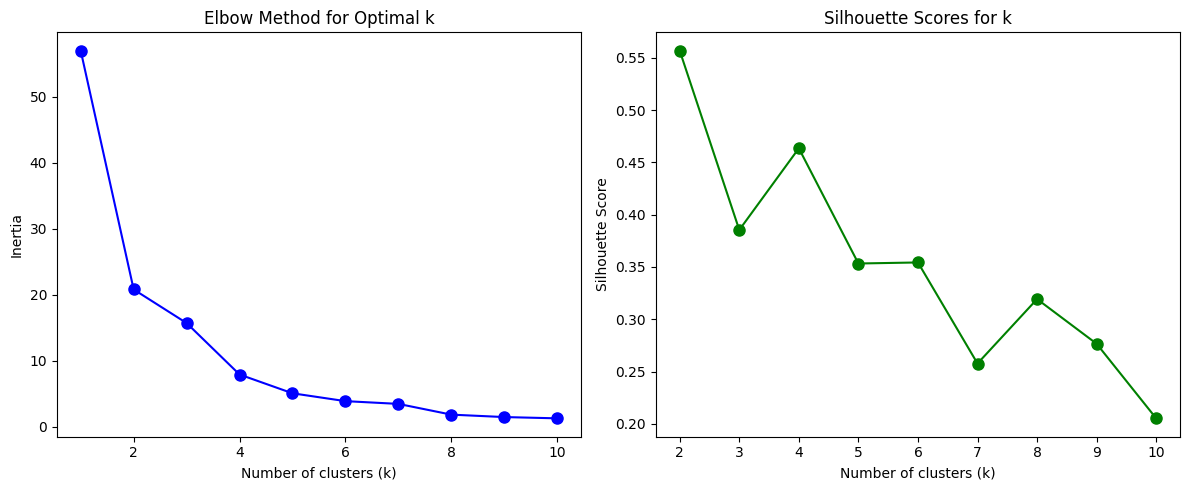

In [13]:
# Data preparation
columns_to_cluster = ['ATROPELLO', 'CHOQUE', 'VOLCAMIENTO']
df_cluster = df_localidad[columns_to_cluster].copy()

# Standardize the data
scaler = StandardScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster)

# Elbow method to find optimal number of clusters
inertia = []
silhouette_scores = []
K_range = range(1, 11)  # Test 1-10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_cluster_scaled)
    inertia.append(kmeans.inertia_)
    if k > 1:
        silhouette_scores.append(silhouette_score(df_cluster_scaled, kmeans.labels_))

# Plot the Elbow Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, 'bo-', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

# Plot the Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K_range[1:], silhouette_scores, 'go-', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for k')

plt.tight_layout()
plt.show()

In [14]:
# Apply K-Means with the chosen number of clusters
k_optimal = 4  # Replace this with the optimal k from the elbow method
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
df_cluster['KMeans_Cluster'] = kmeans.fit_predict(df_cluster_scaled)

# Add the cluster labels back to the original DataFrame
df_3d['KMeans_Cluster'] = df_cluster['KMeans_Cluster'].values


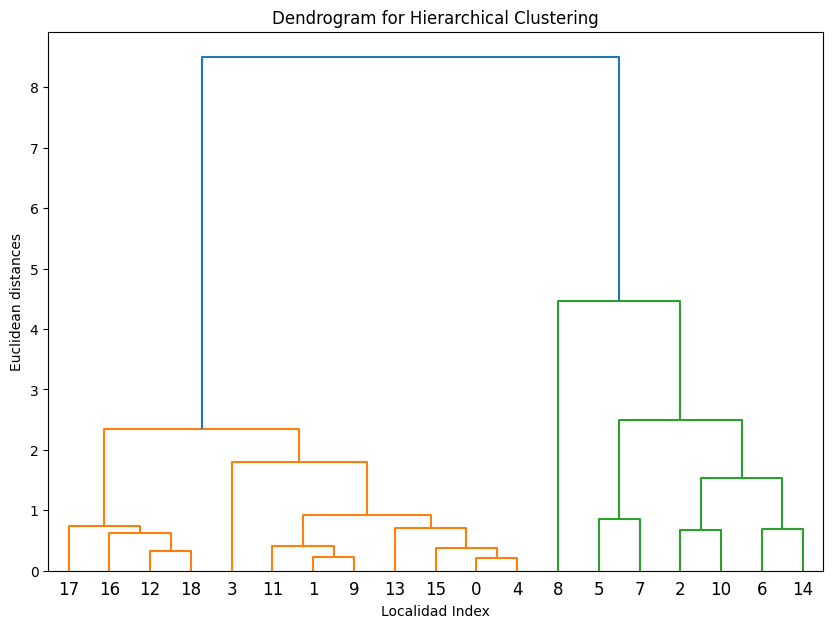

In [15]:
# Hierarchical Clustering Dendrogram
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(df_cluster_scaled, method='ward'))
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Localidad Index')
plt.ylabel('Euclidean distances')
plt.show()

In [16]:
# Plotly 3D Scatter for K-Means clusters
fig = px.scatter_3d(
    df_3d,
    x='ATROPELLO',
    y='CHOQUE',
    z='VOLCAMIENTO',
    color='KMeans_Cluster',
    title="3D Plot of Accident Types with K-Means Clusters",
    labels={'ATROPELLO': 'Atropello', 'CHOQUE': 'Choque', 'VOLCAMIENTO': 'Volcamiento'},
    opacity=0.7
)

fig.update_traces(marker=dict(size=5))
fig.update_layout(scene=dict(
    xaxis_title='ATROPELLO',
    yaxis_title='CHOQUE',
    zaxis_title='VOLCAMIENTO'
))

fig.show()

In [17]:
# Display the number of LOCALIDAD in each cluster to see distribution
localidad_distribution = df_cluster.groupby('KMeans_Cluster').size()
print("\nDistribution of LOCALIDAD across clusters:")
print(localidad_distribution)

# Display detailed insights per cluster, focusing on statistics and LOCALIDAD breakdown
for cluster_id in df_cluster['KMeans_Cluster'].unique():
    print(f"\nCluster {cluster_id} Stats:")

    # Filter data for the current cluster
    cluster_data = df_cluster[df_cluster['KMeans_Cluster'] == cluster_id]

    # Summary statistics
    summary = cluster_data[columns_to_cluster].agg(['mean', 'min', 'max'])
    print(summary)

    # LOCALIDADs in the current cluster
    print("\nLOCALIDAD in this cluster:")
    print(cluster_data.index.tolist())



Distribution of LOCALIDAD across clusters:
KMeans_Cluster
0     2
1    11
2     5
3     1
dtype: int64

Cluster 1 Stats:
CLASE_ACC  ATROPELLO  CHOQUE  VOLCAMIENTO
mean       51.181818    44.0     6.909091
min         8.000000     6.0     1.000000
max        66.000000    68.0    15.000000

LOCALIDAD in this cluster:
['ANTONIO NARINO', 'BARRIOS UNIDOS', 'CANDELARIA', 'CHAPINERO', 'LOS MARTIRES', 'RAFAEL URIBE URIBE', 'SAN CRISTOBAL', 'SANTA FE', 'TEUSAQUILLO', 'TUNJUELITO', 'USME']

Cluster 2 Stats:
CLASE_ACC  ATROPELLO  CHOQUE  VOLCAMIENTO
mean            94.6   112.6         18.2
min             61.0    79.0         14.0
max            133.0   135.0         23.0

LOCALIDAD in this cluster:
['BOSA', 'ENGATIVA', 'PUENTE ARANDA', 'SUBA', 'USAQUEN']

Cluster 0 Stats:
CLASE_ACC  ATROPELLO  CHOQUE  VOLCAMIENTO
mean            90.5   111.5         34.0
min             77.0   106.0         31.0
max            104.0   117.0         37.0

LOCALIDAD in this cluster:
['CIUDAD BOLIVAR', 'FONTIBON'

## 7.2 Aggregation by Hour and Accident Type (Atropello)

In [18]:
# Combine 'CLASE_ACC' and 'Hour'
df_selected['CLASE_ACC_HORA'] = df_selected['CLASE_ACC'] + '_' + df_selected['Hour'].astype(str)
df_hora = df_selected.groupby(['LOCALIDAD', 'CLASE_ACC_HORA']).size().unstack(fill_value=0)
df_hora.head()

CLASE_ACC_HORA,ATROPELLO_0,ATROPELLO_1,ATROPELLO_10,ATROPELLO_11,ATROPELLO_12,ATROPELLO_13,ATROPELLO_14,ATROPELLO_15,ATROPELLO_16,ATROPELLO_17,...,VOLCAMIENTO_21,VOLCAMIENTO_22,VOLCAMIENTO_23,VOLCAMIENTO_3,VOLCAMIENTO_4,VOLCAMIENTO_5,VOLCAMIENTO_6,VOLCAMIENTO_7,VOLCAMIENTO_8,VOLCAMIENTO_9
LOCALIDAD,,,,,,,,,,,,,,,,,,,,,
ANTONIO NARINO,0,0,3,3,1,1,1,2,1,4,...,0,0,0,0,0,0,0,0,0,0
BARRIOS UNIDOS,0,4,1,3,4,4,0,2,0,2,...,0,0,0,0,1,1,1,0,0,0
BOSA,1,3,5,2,1,6,4,2,3,4,...,1,0,1,2,0,1,0,0,0,0
CANDELARIA,0,0,1,2,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
CHAPINERO,2,0,3,3,1,2,1,1,1,3,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Extract columns with 'ATROPELLO' in their names.
atro_cols = [col for col in df_hora.columns if 'ATROPELLO' in col]
df_atro = df_hora[atro_cols]

In [20]:
# Sort columns based on the hour part in the column name
sorted_cols = sorted(atro_cols, key=lambda x: int(x.split('_')[1]))

# Reassign the sorted columns to the original DataFrame variable
df_atro = df_atro[sorted_cols]

df_atro.head()

CLASE_ACC_HORA,ATROPELLO_0,ATROPELLO_1,ATROPELLO_2,ATROPELLO_3,ATROPELLO_4,ATROPELLO_5,ATROPELLO_6,ATROPELLO_7,ATROPELLO_8,ATROPELLO_9,...,ATROPELLO_14,ATROPELLO_15,ATROPELLO_16,ATROPELLO_17,ATROPELLO_18,ATROPELLO_19,ATROPELLO_20,ATROPELLO_21,ATROPELLO_22,ATROPELLO_23
LOCALIDAD,,,,,,,,,,,,,,,,,,,,,
ANTONIO NARINO,0,0,0,1,1,0,2,3,0,2,...,1,2,1,4,2,3,3,3,3,3
BARRIOS UNIDOS,0,4,0,0,1,2,2,1,1,1,...,0,2,0,2,5,5,3,1,5,2
BOSA,1,3,1,3,2,7,1,3,6,3,...,4,2,3,4,3,3,2,3,4,2
CANDELARIA,0,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,1,0
CHAPINERO,2,0,1,2,1,2,1,0,1,4,...,1,1,1,3,6,2,1,4,3,0


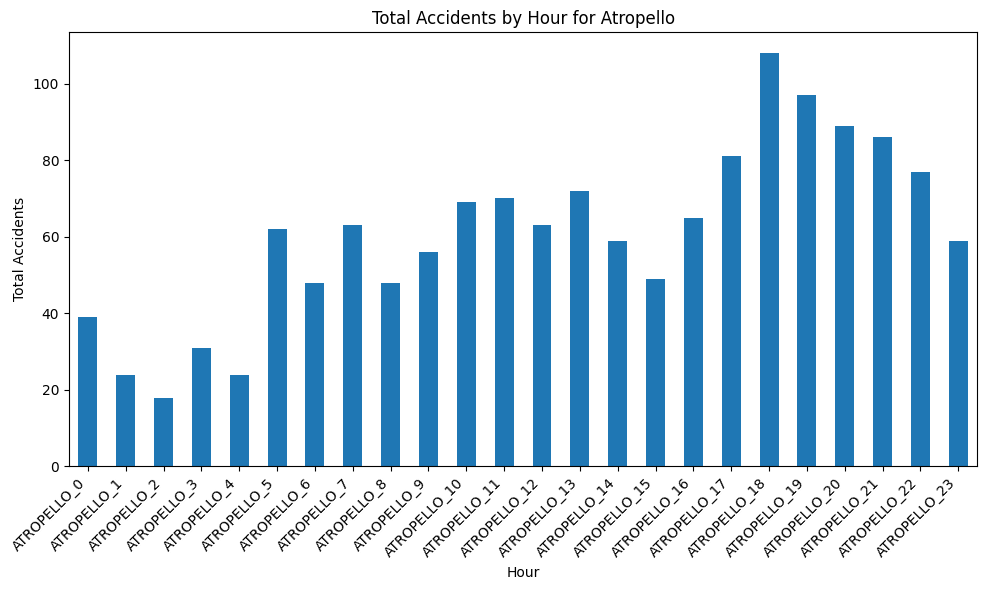

In [21]:
# Sum of Atropeellos by Hour
sum = df_atro.sum()

# Create a bar plot
sum.plot(kind='bar', figsize=(10, 6))

plt.title('Total Accidents by Hour for Atropello')
plt.xlabel('Hour')
plt.ylabel('Total Accidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

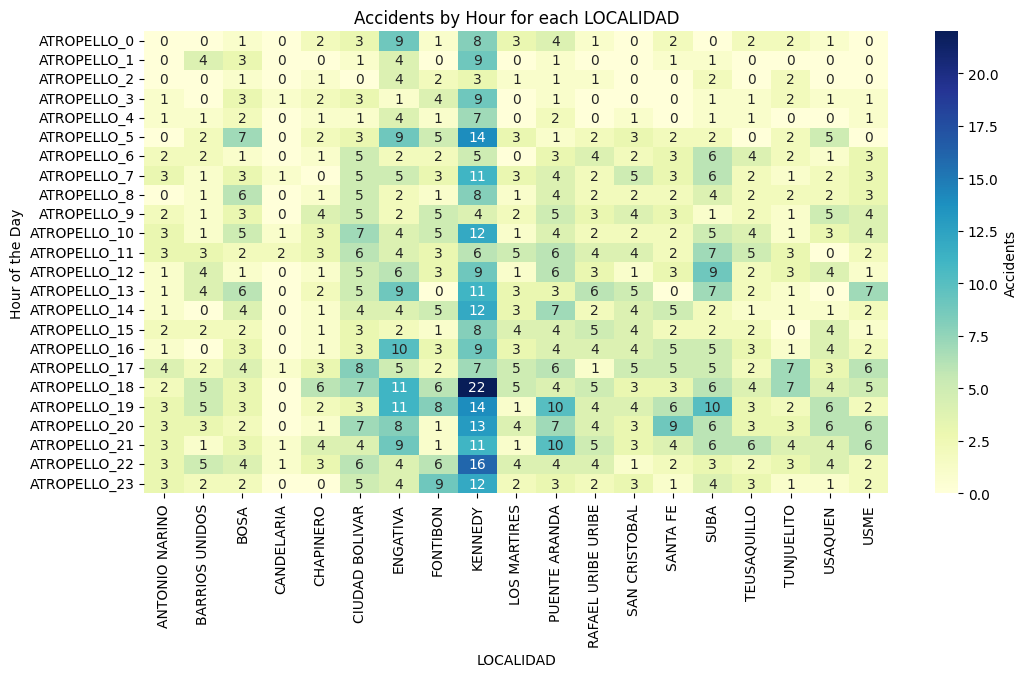

In [22]:
# Create a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df_atro.T, annot=True, cmap="YlGnBu", fmt='d', cbar_kws={'label': 'Accidents'}, xticklabels=df_atro.index, yticklabels=df_atro.columns)
plt.title('Accidents by Hour for each LOCALIDAD')
plt.xlabel('LOCALIDAD')
plt.ylabel('Hour of the Day')
plt.show()

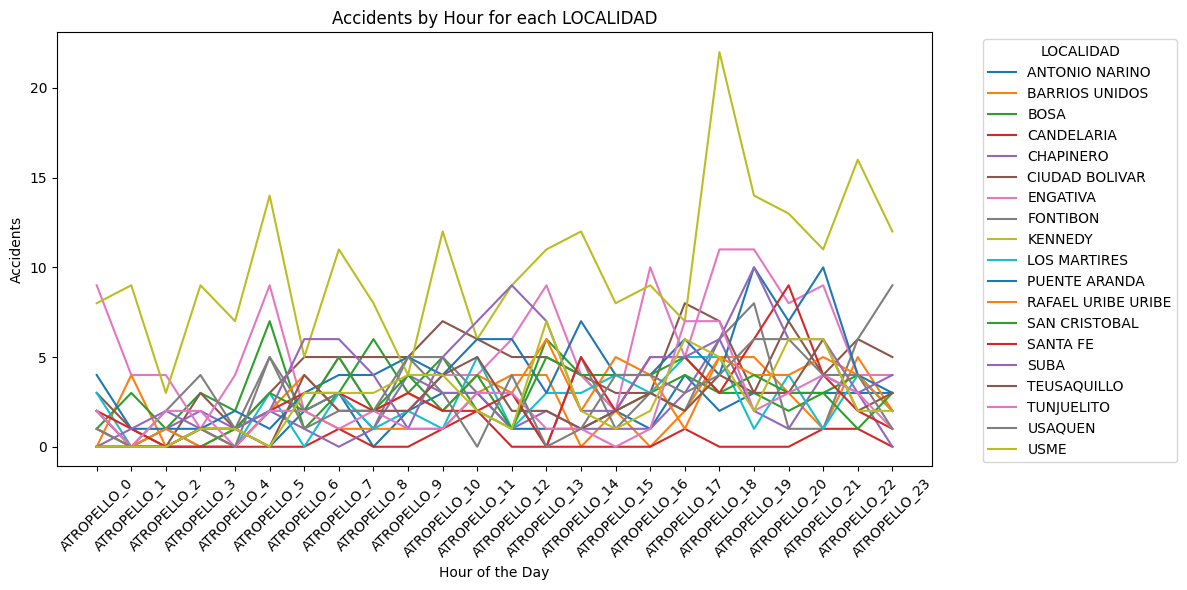

In [23]:
# Plotting each locality's accident trend
plt.figure(figsize=(12, 6))

for locality in df_atro.index:
    plt.plot(df_atro.columns, df_atro.loc[locality], label=locality)

plt.title('Accidents by Hour for each LOCALIDAD')
plt.xlabel('Hour of the Day')
plt.ylabel('Accidents')
plt.legend(title='LOCALIDAD', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

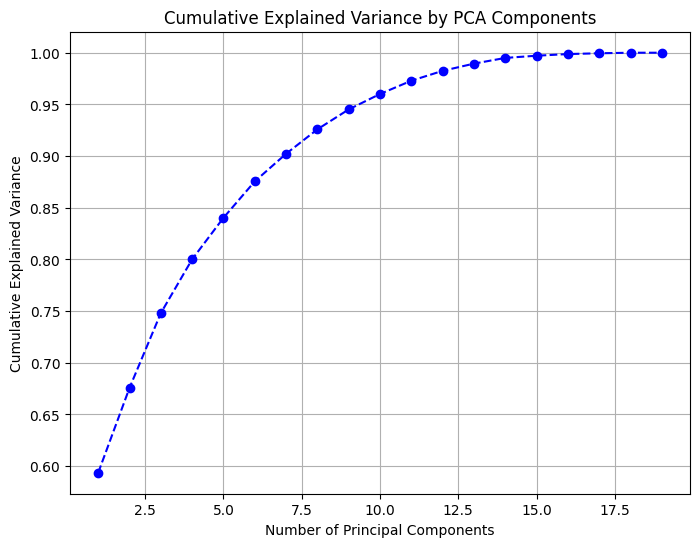

In [24]:
# Standardize the data
scaler = StandardScaler()
df_atro_scaled = scaler.fit_transform(df_atro)

#  Apply PCA
pca = PCA()
pca.fit(df_atro_scaled)

# Plot the cumulative variance explained by each PC
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [25]:
# Get the principal components' loadings (feature weights)
pca_loadings = pd.DataFrame(pca.components_, columns=df_atro.columns)

# Display the top most important features for each principal component
num_top_features = 3
num_pc = 3

for i in range(3):
    top_features = pca_loadings.iloc[i].abs().sort_values(ascending=False).head(num_top_features)
    print(f"PC {i+1} - Top {num_top_features} Most Representative Features:")
    print(top_features)
    print("\n")

PC 1 - Top 3 Most Representative Features:
CLASE_ACC_HORA
ATROPELLO_7     0.240930
ATROPELLO_18    0.240841
ATROPELLO_4     0.240029
Name: 0, dtype: float64


PC 2 - Top 3 Most Representative Features:
CLASE_ACC_HORA
ATROPELLO_6     0.469268
ATROPELLO_11    0.384704
ATROPELLO_5     0.343216
Name: 1, dtype: float64


PC 3 - Top 3 Most Representative Features:
CLASE_ACC_HORA
ATROPELLO_9    0.508104
ATROPELLO_2    0.412725
ATROPELLO_0    0.268573
Name: 2, dtype: float64




In [26]:
# Apply PCA with 3 components
pca = PCA(n_components=3)
df_atro_pca = pca.fit_transform(df_atro_scaled)

# Create a DataFrame with the PCA results and the 'LOCALIDAD' index
pca_df = pd.DataFrame(df_atro_pca, columns=['PC1', 'PC2', 'PC3'], index=df_atro.index)
pca_df['LOCALIDAD'] = pca_df.index

# Create the 3D scatter plot with Plotly
fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color='LOCALIDAD',
                    title='3D PCA Plot: Accidents by Hour',
                    labels={'LOCALIDAD': 'Locality'},
                    color_continuous_scale='Viridis')

# Show the plot
fig.show()

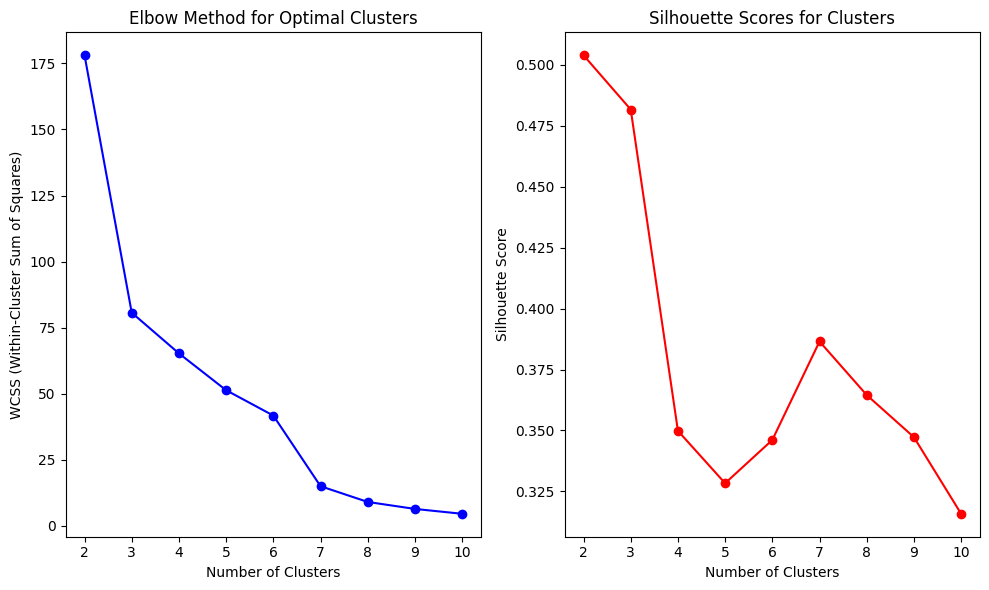

In [27]:
# Compute the Elbow Method
wcss = []
silhouette_scores = []

# Loop through different cluster numbers
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(df_atro_pca)  # Using PCA-transformed data

    # Calculate WCSS (Within-Cluster Sum of Squares) for Elbow Method
    wcss.append(kmeans.inertia_)

    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(df_atro_pca, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Plotting the Elbow Method
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), wcss, marker='o', color='b')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')

# Plotting Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o', color='r')
plt.title('Silhouette Scores for Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [28]:
# Convert PCA result to DataFrame
pca_df = pd.DataFrame(df_atro_pca, columns=['PC1', 'PC2', 'PC3'], index=df_atro.index)

# Apply KMeans with the chosen 5 clusters
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)

# Apply the KMeans clustering and store the cluster labels
pca_df['Cluster'] = kmeans.fit_predict(pca_df[['PC1', 'PC2', 'PC3']])

# Verify the DataFrame with the added 'Cluster' column
print(pca_df.head())

                     PC1       PC2       PC3  Cluster
LOCALIDAD                                            
ANTONIO NARINO -2.696624 -0.048898  0.420362        2
BARRIOS UNIDOS -2.281603 -0.769766 -0.759171        2
BOSA            0.014626 -1.781058  0.848679        2
CANDELARIA     -5.318943 -1.460400 -0.692907        2
CHAPINERO      -2.572069 -1.162019  0.153181        2


In [29]:
# Create the 3D scatter plot with Plotly, coloring by clusters
fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color='Cluster',
                    title='3D PCA Plot: Accidents by Hour (KMeans Clusters)',
                    labels={'Cluster': 'Cluster'},
                    color_continuous_scale='Viridis')

# Show the plot
fig.show()

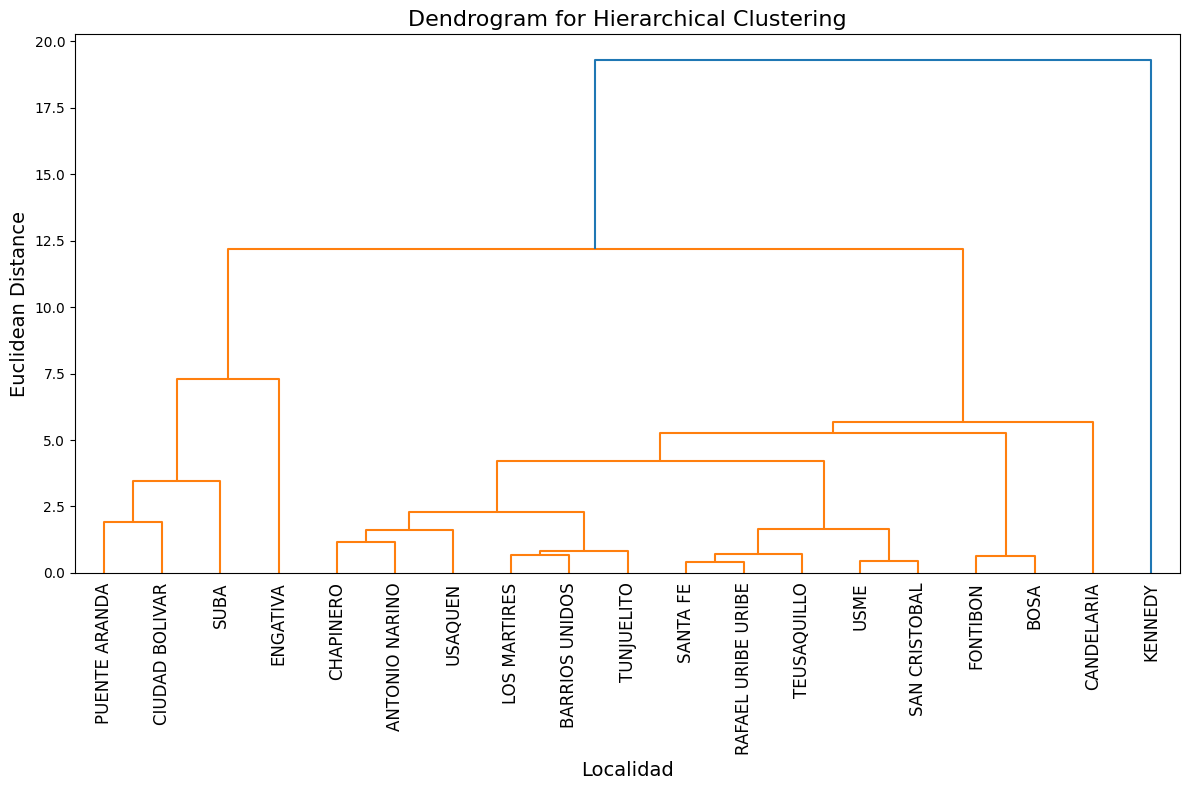

In [32]:
# Apply Hierarchical Clustering (using Ward's method)
linked = linkage(df_atro_pca, method='ward')

# Create the Dendrogram
plt.figure(figsize=(12, 8))  # Set figure size for better visualization
dendrogram(
    linked,
    labels=df_atro.index,  # Localidades as labels
    orientation='top',      # Dendrogram orientation
    distance_sort='descending',  # Sort by distance
    show_leaf_counts=True   # Show count of points in each cluster
)

# Customize plot
plt.title('Dendrogram for Hierarchical Clustering', fontsize=16)
plt.xlabel('Localidad', fontsize=14)
plt.ylabel('Euclidean Distance', fontsize=14)

# Rotate x-axis labels to make them vertical for better readability
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent label clipping
plt.show()

In [33]:
# Distribution of Localidades across clusters
print("Distribution of LOCALIDAD across clusters:")
print(pca_df['Cluster'].value_counts())

# Generate stats for each cluster based on PCA components
for cluster_num in pca_df['Cluster'].unique():
    print(f"\nCluster {cluster_num} Stats:")

    # Filter data for the current cluster
    cluster_data = pca_df[pca_df['Cluster'] == cluster_num]

    # Calculate mean, min, and max for each PCA component (PC1, PC2, PC3)
    stats = cluster_data[['PC1', 'PC2', 'PC3']].agg(['mean', 'min', 'max'])
    print(stats)

    # List localities in this cluster
    localities_in_cluster = cluster_data.index.tolist()
    print(f"\nLOCALIDAD in this cluster:\n{localities_in_cluster}")

Distribution of LOCALIDAD across clusters:
Cluster
2    14
0     4
1     1
Name: count, dtype: int64

Cluster 2 Stats:
           PC1       PC2       PC3
mean -1.712793 -0.325100  0.157624
min  -5.318943 -2.158399 -1.111882
max   0.016262  1.047137  1.374385

LOCALIDAD in this cluster:
['ANTONIO NARINO', 'BARRIOS UNIDOS', 'BOSA', 'CANDELARIA', 'CHAPINERO', 'FONTIBON', 'LOS MARTIRES', 'RAFAEL URIBE URIBE', 'SAN CRISTOBAL', 'SANTA FE', 'TEUSAQUILLO', 'TUNJUELITO', 'USAQUEN', 'USME']

Cluster 0 Stats:
           PC1       PC2       PC3
mean  2.704251  1.527487 -0.781838
min   2.008916 -0.914215 -4.092822
max   4.471303  3.067953  2.206572

LOCALIDAD in this cluster:
['CIUDAD BOLIVAR', 'ENGATIVA', 'PUENTE ARANDA', 'SUBA']

Cluster 1 Stats:
            PC1       PC2       PC3
mean  13.162093 -1.558549  0.920617
min   13.162093 -1.558549  0.920617
max   13.162093 -1.558549  0.920617

LOCALIDAD in this cluster:
['KENNEDY']
